# Use Case Name : UC00204_Resilient_Education_Access

# Authored by: Ekanayake Mudiyanselage Ruvinya Yasasmee Ekanayake

Duration - 90 mins

Level - Intermediate

Pre-requisite Skills - Python, Pandas, Data visuaization, Data handling, Data cleaning

# Objective

Quantify and anticipate school-age (5-19) demand across the City of Melbourne, identify suburb-level capacity shortages and geographic resilience concerns from existing school sites, and create a clear, time-phased seats/schools build plan by target year.


# Datasets

School Locations Dataset (2024): Includes geographic details of schools in Melbourne.

Population Forecasts Dataset (2020–2040): Provides suburb-level forecasts, including age groups and year-wise projections.

## Imports

This imports cell loads the notebook's core tools: pandas and numpy for data manipulation and numerical work, matplotlib for quick visualizations, requests for fetching data from the web (API/CSV URLs), math for small numeric helpers and folium for optional map views using latitude/longitude. Collecting these up front ensures consistency in the environment and prevents dispersed, repeating imports later.

In [130]:
import pandas as pd
import numpy as np
import math
import requests
import matplotlib.pyplot as plt
import folium

Specifies the two hosted data sources: School Locations 2024 (supply) and City of Melbourne Population Forecasts 2020-2040 via API v2.1 (demand). Using URLs makes the notebook repeatable.

In [131]:

# School locations dataset
SCHOOLS_URL = "https://www.education.vic.gov.au/Documents/about/research/datavic/dv378_DataVic-SchoolLocations-2024.csv"

# Population forecast dataset
POP_URL = "https://data.melbourne.vic.gov.au/api/v2/catalog/datasets/city-of-melbourne-population-forecasts-by-small-area-2020-2040/exports/csv?delimiter=%2C"


## Loading datasets

Reads School Locations (CSV) and City of Melbourne Population Forecasts (API v2.1 CSV) into DataFrames. To handle special characters in the schools file, use ISO-8859-1, and set low_memory=False for reliable types. Prints raw shapes and displays the first six rows to ensure schema and connectivity.

In [132]:
school_df = pd.read_csv(SCHOOLS_URL, encoding="ISO-8859-1", low_memory=False)
pop_df = pd.read_csv(POP_URL, low_memory=False)

print("Raw shapes:", school_df.shape, pop_df.shape)
display(school_df.head(6))
display(pop_df.head(6))


Raw shapes: (2294, 22) (10584, 5)


,Education_Sector,Entity_Type,School_No,School_Name,School_Type,Address_Line_1,Address_Line_2,Address_Town,Address_State,Address_Postcode,...,Postal_Town,Postal_State,Postal_Postcode,Full_Phone_No,Region_Name,AREA_Name,LGA_ID,LGA_Name,X,Y
0,Catholic,2,20,Parade College,Secondary,1436 Plenty Road,NaN,BUNDOORA,VIC,3083,...,BUNDOORA,VIC,3083.0,03 9468 3300,NORTH-WESTERN VICTORIA,North Eastern Melbourne,66,Banyule (C),145.06698,-37.69018
1,Catholic,2,25,Simonds Catholic College,Secondary,273 Victoria Street,NaN,WEST MELBOURNE,VIC,3003,...,WEST MELBOURNE,VIC,3003.0,03 9321 9200,SOUTH-WESTERN VICTORIA,Western Melbourne,460,Melbourne (C),144.95288,-37.80597
2,Catholic,2,26,St Marys College Melbourne,Secondary,11 Westbury Street,NaN,ST KILDA EAST,VIC,3183,...,ST KILDA,VIC,3182.0,03 9529 6611,SOUTH-EASTERN VICTORIA,Bayside Peninsula,590,Port Phillip (C),144.99700,-37.85936
3,Catholic,2,28,St Patrick's College Ballarat,Secondary,1431 Sturt Street,NaN,BALLARAT,VIC,3350,...,BALLARAT,VIC,3350.0,03 5331 1688,SOUTH-WESTERN VICTORIA,Central Highlands,57,Ballarat (C),143.83156,-37.55971
4,Catholic,2,29,St Patrick's School,Primary,119 Drummond Street South,NaN,BALLARAT,VIC,3350,...,BALLARAT WEST,VIC,3350.0,03 5332 7680,SOUTH-WESTERN VICTORIA,Central Highlands,57,Ballarat (C),143.84715,-37.56440
5,Catholic,2,30,St Alipius' Parish School,Primary,106-108 Victoria Street,NaN,BALLARAT EAST,VIC,3350,...,BALLARAT EAST,VIC,3350.0,03 5331 1816,SOUTH-WESTERN VICTORIA,Central Highlands,57,Ballarat (C),143.87401,-37.56170


,geography,year,gender,age,value
0,Carlton,2023,Female,Age 65-69,224
1,Carlton,2023,Female,Age 85+,66
2,Carlton,2024,Female,Age 25-29,2105
3,Carlton,2024,Female,Age 30-34,1174
4,Carlton,2024,Male,Age 25-29,1978
5,Carlton,2024,Male,Age 65-69,109


## Standardize column names for merging

Columns are renamed to a common schema for easier joins, including suburb (from Address_Town), lon and lat (from X and Y), and standard fields school_name, sector, school_type, lga, area, year, age_group, and population. Prints the revised column lists for verification.


In [133]:
# Schools: standardize / add suburb
school_df = school_df.rename(columns={
    "School_Name":"school_name",
    "Education_Sector":"sector",
    "School_Type":"school_type",
    "LGA_Name":"lga",
    "Address_Town":"suburb",   # will align with pop_df['area']
    "X":"lon",                 # longitude
    "Y":"lat"                  # latitude
})

# Population: standardize
pop_df = pop_df.rename(columns={
    "geography":"area",
    "year":"year",
    "age":"age_group",
    "value":"population"
})

print("School cols:", school_df.columns.tolist())
print("Pop cols:", pop_df.columns.tolist())


School cols: ['sector', 'Entity_Type', 'School_No', 'school_name', 'school_type', 'Address_Line_1', 'Address_Line_2', 'suburb', 'Address_State', 'Address_Postcode', 'Postal_Address_Line_1', 'Postal_Address_Line_2', 'Postal_Town', 'Postal_State', 'Postal_Postcode', 'Full_Phone_No', 'Region_Name', 'AREA_Name', 'LGA_ID', 'lga', 'lon', 'lat']
Pop cols: ['area', 'year', 'gender', 'age_group', 'population']


## Data Cleaning

Schools

Selects relevant columns, converts lat/lon to numeric, removes invalid rows, normalizes text (strip + title-case), de-duplicates by name/LGA/suburb/coordinates, and outputs the cleaned shape and a preview.

In [134]:
# Keep only needed columns
school_df = school_df[["school_name","sector","school_type","lga","suburb","lat","lon"]].copy()

# Coords numeric + drop invalids
school_df["lat"] = pd.to_numeric(school_df["lat"], errors="coerce")
school_df["lon"] = pd.to_numeric(school_df["lon"], errors="coerce")
school_df = school_df.dropna(subset=["lat","lon"])

# Normalize text
for c in ["school_name","sector","school_type","lga","suburb"]:
    school_df[c] = school_df[c].astype(str).str.strip().str.title()

# Deduplicate
school_df = school_df.drop_duplicates(subset=["school_name","lga","suburb","lat","lon"])

print("Schools (clean):", school_df.shape)
display(school_df.head(3))


Schools (clean): (2293, 7)


,school_name,sector,school_type,lga,suburb,lat,lon
0,Parade College,Catholic,Secondary,Banyule (C),Bundoora,-37.69018,145.06698
1,Simonds Catholic College,Catholic,Secondary,Melbourne (C),West Melbourne,-37.80597,144.95288
2,St MaryS College Melbourne,Catholic,Secondary,Port Phillip (C),St Kilda East,-37.85936,144.99700


Population

Contains just area, year, age_group, and population. Converts year and population to numeric. Trims and title-cases text. Removes invalid entries. Limits projected years to ≥ 2025. Prints the cleaned form with a short preview.


In [135]:
pop_df = pop_df[["area","year","age_group","population"]].copy()

pop_df["year"] = pd.to_numeric(pop_df["year"], errors="coerce")
pop_df["population"] = pd.to_numeric(pop_df["population"], errors="coerce")

for c in ["area","age_group"]:
    pop_df[c] = pop_df[c].astype(str).str.strip().str.title()

# Drop invalids and keep forecast years 
pop_df = pop_df.dropna(subset=["year","population"])
pop_df = pop_df[pop_df["year"] >= 2025]

print("Population (clean):", pop_df.shape)
display(pop_df.head(3))


Population (clean): (9576, 4)


,area,year,age_group,population
6,Carlton,2025,Age 35-39,811
7,Carlton,2025,Age 80-84,131
8,Carlton,2025,Age 80-84,54


## Aggregate school-age (5-19) population by year, location, and citywide total

The population is filtered to ages 5-9, 10-14, and 15-19, and then aggregated by (year, area) to yield school_age_pop. A citywide total is also computed by year. Prints brief previews to check the outcomes.

In [136]:
school_age_mask = pop_df["age_group"].str.contains(r"5-9|10-14|15-19")

school_age = (
    pop_df[school_age_mask]
    .groupby(["year","area"], as_index=False)["population"]
    .sum()
    .rename(columns={"population":"school_age_pop"})
)

city_school_age = school_age.groupby("year", as_index=False)["school_age_pop"].sum()

print("School-age per area/year:")
display(school_age.head(10))
print("Citywide school-age total by year:")
display(city_school_age.head(10))


School-age per area/year:


,year,area,school_age_pop
0,2025,Carlton,2656
1,2025,City Of Melbourne,15995
2,2025,Docklands,1123
3,2025,East Melbourne,152
4,2025,Kensington,1413
5,2025,Melbourne (Cbd),4487
6,2025,Melbourne (Remainder),152
7,2025,North Melbourne,1928
8,2025,Parkville,1662
9,2025,Port Melbourne,2


Citywide school-age total by year:


,year,school_age_pop
0,2025,31991
1,2026,32614
2,2027,33616
3,2028,34942
4,2029,36259
5,2030,37778
6,2031,39517
7,2032,41066
8,2033,42852
9,2034,44665


## Estimate capacity according to school type

Maps each school's school_type to an approximate seat capacity (Primary≈500, Secondary≈1000, P-12≈800, Special≈200; 600 fallback), constructs a capacity column, sums to a citywide total, and provides a simplified capacity breakdown by type and sector.

In [137]:
def estimate_capacity(t):
    t = str(t).lower()
    if "primary"   in t: return 500
    if "secondary" in t: return 1000
    if "p-12" in t or "pri/sec" in t: return 800
    if "special"   in t: return 200
    return 600  # fallback

school_df["capacity"] = school_df["school_type"].apply(estimate_capacity)
total_capacity = int(school_df["capacity"].sum())

print("Estimated total city capacity:", total_capacity)
display(school_df.groupby(["school_type","sector"], as_index=False)["capacity"].sum())


Estimated total city capacity: 1365400


,school_type,sector,capacity
0,Language,Government,2400
1,Pri/Sec,Catholic,10400
2,Pri/Sec,Government,64000
3,Pri/Sec,Independent,124800
4,Primary,Catholic,196000
5,Primary,Government,572000
6,Primary,Independent,17000
7,Secondary,Catholic,84000
8,Secondary,Government,257000
9,Secondary,Independent,15000


## Citywide demand vs capacity

Ensures that the capacity figure is derived solely from City of Melbourne schools (creates schools_com and estimates per-type capacity as needed), then combines citywide school-age demand with that capacity to calculate the annual gap and the critical year when demand first surpasses supply. Finally, it maps demand vs capacity, darkening the shortage area and identifying the important year.

First year demand exceeds capacity: 2025


,year,school_age_pop,capacity,gap
0,2025,31991,15900,16091
1,2026,32614,15900,16714
2,2027,33616,15900,17716
3,2028,34942,15900,19042
4,2029,36259,15900,20359
5,2030,37778,15900,21878
6,2031,39517,15900,23617
7,2032,41066,15900,25166
8,2033,42852,15900,26952
9,2034,44665,15900,28765


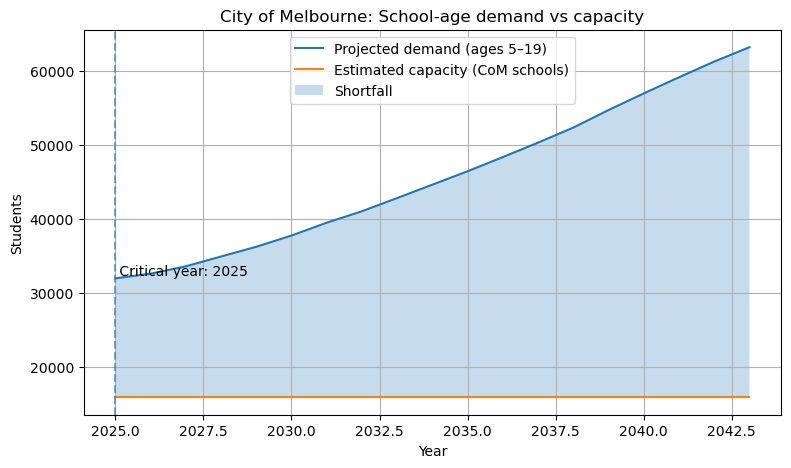

In [138]:
# City of Melbourne demand vs capacity
try:
    total_capacity = int(schools_com["capacity"].sum())
except NameError:
    # build CoM subset + capacity if not already done
    schools_com = school_df[school_df["lga"].str.strip().eq("Melbourne (C)")].copy()
    def estimate_capacity(t):
        t = str(t).lower()
        if "primary"   in t: return 500
        if "secondary" in t: return 1000
        if "p-12" in t or "pri/sec" in t: return 800
        if "special"   in t: return 200
        return 600
    schools_com["capacity"] = schools_com["school_type"].apply(estimate_capacity)
    total_capacity = int(schools_com["capacity"].sum())

# build table
demand_vs_capacity = city_school_age.copy()       # CoM school-age totals by year
demand_vs_capacity["capacity"] = total_capacity
demand_vs_capacity["gap"] = demand_vs_capacity["school_age_pop"] - demand_vs_capacity["capacity"]

critical_year = (
    demand_vs_capacity.loc[demand_vs_capacity["gap"] > 0, "year"].min()
    if (demand_vs_capacity["gap"] > 0).any() else None
)
print("First year demand exceeds capacity:", critical_year)
display(demand_vs_capacity.head(12))

# plot
plt.figure(figsize=(9,5))
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["school_age_pop"],
         label="Projected demand (ages 5–19)")
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["capacity"],
         label="Estimated capacity (CoM schools)")
plt.fill_between(
    demand_vs_capacity["year"],
    demand_vs_capacity["capacity"],
    demand_vs_capacity["school_age_pop"],
    where=demand_vs_capacity["gap"] > 0,
    alpha=0.25, label="Shortfall"
)
if critical_year is not None:
    y = demand_vs_capacity.loc[demand_vs_capacity["year"]==critical_year, "school_age_pop"].values[0]
    plt.axvline(critical_year, linestyle="--", alpha=0.6)
    plt.text(critical_year, y, f" Critical year: {critical_year}", va="bottom")

plt.xlabel("Year"); plt.ylabel("Students")
plt.title("City of Melbourne: School-age demand vs capacity")
plt.legend(); plt.grid(True); plt.show()


## Shortfall given as school counts - Primary and Secondary

This converts the annual gap to equivalent school counts by dividing it by ~500 (primary) and ~1000 (secondary), rounding up, and displaying a compact table for planning.

In [139]:
dvc = demand_vs_capacity.copy()
dvc["shortfall"] = np.maximum(dvc["gap"], 0)
dvc["primary_schools_needed_~500"]   = np.ceil(dvc["shortfall"] / 500).astype(int)
dvc["secondary_schools_needed_~1000"] = np.ceil(dvc["shortfall"] / 1000).astype(int)

display(dvc[["year","school_age_pop","capacity","gap",
             "primary_schools_needed_~500","secondary_schools_needed_~1000"]].head(15))


,year,school_age_pop,capacity,gap,primary_schools_needed_~500,secondary_schools_needed_~1000
0,2025,31991,15900,16091,33,17
1,2026,32614,15900,16714,34,17
2,2027,33616,15900,17716,36,18
3,2028,34942,15900,19042,39,20
4,2029,36259,15900,20359,41,21
5,2030,37778,15900,21878,44,22
6,2031,39517,15900,23617,48,24
7,2032,41066,15900,25166,51,26
8,2033,42852,15900,26952,54,27
9,2034,44665,15900,28765,58,29


## Suburban demand-supply gap (Target year)

This cell shows when demand exceeds supply in a particular year. It selects a target year (by default, the most recent), averages the 5-19 population for each suburb to calculate future demand, and standardizes suburb names. 

It then adds the capacity of all City of Melbourne schools in each area to generate supply, combines the two tables, and calculates a gap (demand minus supply), treating suburbs without schools as having zero supply. Finally, it ranks suburbs based on the largest positive gaps, resulting in a clear, ordered list of priority sites for more places.


In [140]:
# Use schools_com (CoM schools with capacity) and school_age from earlier cells
TARGET_YEAR = int(school_age["year"].max())  

# Demand (ages 5–19) by suburb
suburb_demand = (
    school_age[school_age["year"] == TARGET_YEAR]
    .groupby("area", as_index=False)["school_age_pop"].sum()
    .rename(columns={"area":"suburb", "school_age_pop":"demand_students"})
)

# Supply (sum of school capacities) by suburb
schools_com["suburb"] = schools_com["suburb"].astype(str).str.strip().str.title()
suburb_supply = (
    schools_com.groupby("suburb", as_index=False)["capacity"].sum()
    .rename(columns={"capacity":"supply_capacity"})
)

# Merge and rank gaps
suburb_gap = suburb_demand.merge(suburb_supply, on="suburb", how="left")
suburb_gap["supply_capacity"] = suburb_gap["supply_capacity"].fillna(0)
suburb_gap["gap_students"] = suburb_gap["demand_students"] - suburb_gap["supply_capacity"]
suburb_gap = suburb_gap.sort_values("gap_students", ascending=False)

print(f"Suburb gaps for {TARGET_YEAR} (top 15):")
display(suburb_gap.head(15))


Suburb gaps for 2043 (top 15):


,suburb,demand_students,supply_capacity,gap_students
1,City Of Melbourne,31632,0.0,31632.0
5,Melbourne (Cbd),7688,0.0,7688.0
0,Carlton,4099,1000.0,3099.0
7,North Melbourne,5412,2400.0,3012.0
2,Docklands,2650,500.0,2150.0
11,Southbank,3098,1000.0,2098.0
13,West Melbourne (Residential),1466,0.0,1466.0
8,Parkville,2643,1200.0,1443.0
4,Kensington,3017,2000.0,1017.0
9,Port Melbourne,470,0.0,470.0


## Worst suburb gaps

Plots the top 12 suburbs with the highest gaps (demand - supply) for TARGET_YEAR. Bars indicate pupil deficiency; rotating labels improve reading; and a y-grid and compact structure make the chart simple to scan.

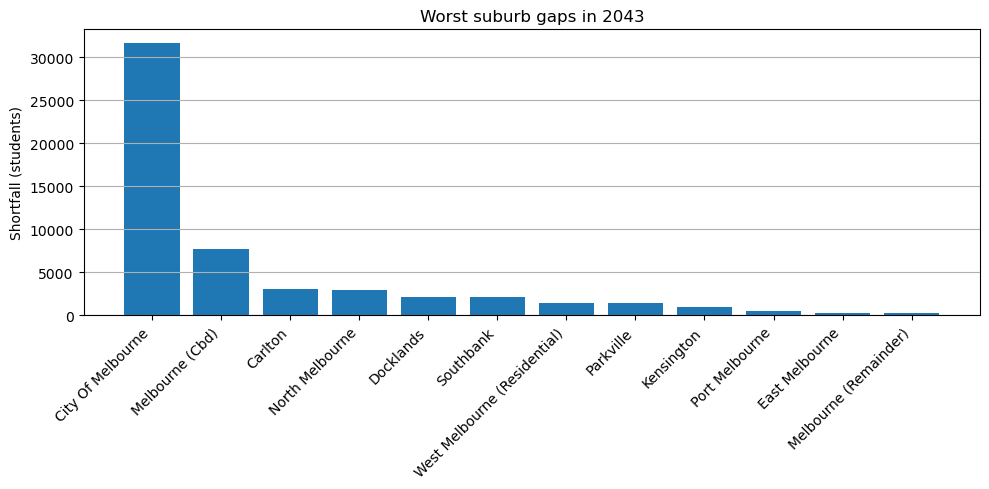

In [141]:
top = suburb_gap.head(12)
plt.figure(figsize=(10,5))
plt.bar(top["suburb"], top["gap_students"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Shortfall (students)")
plt.title(f"Worst suburb gaps in {TARGET_YEAR}")
plt.grid(axis="y"); plt.tight_layout(); plt.show()


## Geographic resilience: nearest-school distance and 2 km redundancy

Creates a simple resilience indicator for the City of Melbourne school network. It calculates the great-circle distance to every other school (Haversine), keeps track of the nearest neighbor distance (nearest_km), and counts how many other schools are within 2 kilometers (within2km). It then aggregates these indicators by suburb and combines them with the suburb demand-supply gaps to create a ranked list of high-risk suburbs—those with significant deficits and few close options. This is an O(n²) check, suitable for dozens of schools. Change the redundancy radius to 2.0 if necessary.

In [142]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2-lat1); dl = math.radians(lon2-lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dl/2)**2
    return 2*R*math.asin(math.sqrt(a))

S = schools_com.reset_index(drop=True).copy()
coords = S[["lat","lon"]].to_numpy()
n = len(S)
nearest = np.full(n, np.nan)
within2 = np.zeros(n, dtype=int)

for i, (la, lo) in enumerate(coords):
    dists = np.array([haversine_km(la, lo, la2, lo2) for la2, lo2 in coords])
    d_ok = dists[dists > 0]
    nearest[i] = d_ok.min() if d_ok.size else np.nan
    within2[i]  = (dists <= 2.0).sum() - 1

S["nearest_km"] = nearest
S["within2km"] = within2

# Summarize by suburb, then join with demand gaps
suburb_resilience = (S.groupby("suburb", as_index=False)
                       .agg(mean_nearest_km=("nearest_km","mean"),
                            total_neighbors_2km=("within2km","sum")))

suburb_risk = suburb_gap.merge(suburb_resilience, on="suburb", how="left")
suburb_risk = suburb_risk.sort_values(["gap_students","mean_nearest_km"],
                                      ascending=[False, False])

print("High-risk suburbs (big gap & sparse nearby schools):")
display(suburb_risk.head(12))


High-risk suburbs (big gap & sparse nearby schools):


,suburb,demand_students,supply_capacity,gap_students,mean_nearest_km,total_neighbors_2km
0,City Of Melbourne,31632,0.0,31632.0,NaN,NaN
1,Melbourne (Cbd),7688,0.0,7688.0,NaN,NaN
2,Carlton,4099,1000.0,3099.0,0.721948,15.0
3,North Melbourne,5412,2400.0,3012.0,0.272406,53.0
4,Docklands,2650,500.0,2150.0,1.218590,5.0
5,Southbank,3098,1000.0,2098.0,1.023062,4.0
6,West Melbourne (Residential),1466,0.0,1466.0,NaN,NaN
7,Parkville,2643,1200.0,1443.0,1.144822,11.0
8,Kensington,3017,2000.0,1017.0,0.412441,13.0
9,Port Melbourne,470,0.0,470.0,NaN,NaN


## Scenario - Stage capacity additions

Tests a simple development design by adding extra seats in specific years (via expansions). The increased capacity accumulates over time (cumsum), the deficit is recalculated each year, and the code publishes the critical year (the first year with a shortfall) in this situation. The figure compares baseline demand to current capacity and the scenario capacity line, darkening any residual gap. Adjust the adds dictionary to try alternative plans.

Critical year with scenario: 2025


,year,school_age_pop,extra,capacity,gap
0,2025,31991,0.0,15900.0,16091.0
1,2026,32614,2000.0,17900.0,14714.0
2,2027,33616,0.0,17900.0,15716.0
3,2028,34942,2000.0,19900.0,15042.0
4,2029,36259,0.0,19900.0,16359.0
5,2030,37778,0.0,19900.0,17878.0
6,2031,39517,3000.0,22900.0,16617.0
7,2032,41066,0.0,22900.0,18166.0
8,2033,42852,0.0,22900.0,19952.0
9,2034,44665,0.0,22900.0,21765.0


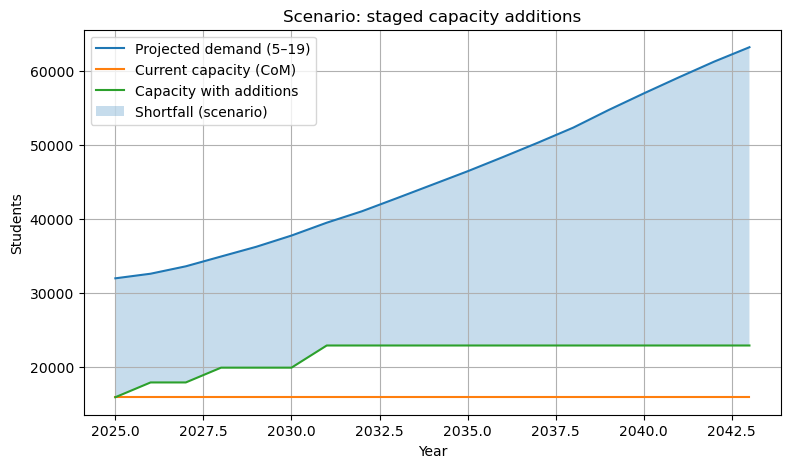

In [143]:
# additions: dict(year - extra seats added that year, cumulative thereafter)
additions = {2026: 2000, 2028: 2000, 2031: 3000}  # example plan

scenario = demand_vs_capacity[["year","school_age_pop"]].copy()
scenario["extra"] = scenario["year"].map(additions).fillna(0)
scenario["capacity"] = total_capacity + scenario["extra"].cumsum()
scenario["gap"] = scenario["school_age_pop"] - scenario["capacity"]

print("Critical year with scenario:",
      scenario.loc[scenario["gap"]>0, "year"].min())
display(scenario.head(12))

plt.figure(figsize=(9,5))
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["school_age_pop"], label="Projected demand (5–19)")
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["capacity"], label="Current capacity (CoM)")
plt.plot(scenario["year"], scenario["capacity"], label="Capacity with additions")
plt.fill_between(scenario["year"], scenario["capacity"], scenario["school_age_pop"],
                 where=scenario["gap"]>0, alpha=0.25, label="Shortfall (scenario)")
plt.xlabel("Year"); plt.ylabel("Students"); plt.title("Scenario: staged capacity additions")
plt.legend(); plt.grid(True); plt.show()


In [144]:
# totals & peak
total_added = int(scenario["extra"].sum())
peak_gap_val = int(scenario["gap"].max())
peak_gap_year = int(scenario.loc[scenario["gap"].idxmax(), "year"])

print("Total seats added in plan:", total_added)
print("Peak shortfall:", peak_gap_val, "students")
print("Peak shortfall year:", peak_gap_year)

# example: check a specific year (change as needed)
gap_2030 = int(scenario.loc[scenario["year"]==2030, "gap"].iloc[0])
print("Gap in 2030:", gap_2030)


Total seats added in plan: 7000
Peak shortfall: 40365 students
Peak shortfall year: 2043
Gap in 2030: 17878


In [145]:
# rough equivalents: primary ~500 seats, secondary ~1000 seats
need = scenario.copy()
need["shortfall"] = need["gap"].clip(lower=0).astype(int)
need["primary_schools(~500)"]   = need["shortfall"].apply(lambda x: math.ceil(x/500))
need["secondary_schools(~1000)"] = need["shortfall"].apply(lambda x: math.ceil(x/1000))

display(need[["year","shortfall","primary_schools(~500)","secondary_schools(~1000)"]].head(12))


,year,shortfall,primary_schools(~500),secondary_schools(~1000)
0,2025,16091,33,17
1,2026,14714,30,15
2,2027,15716,32,16
3,2028,15042,31,16
4,2029,16359,33,17
5,2030,17878,36,18
6,2031,16617,34,17
7,2032,18166,37,19
8,2033,19952,40,20
9,2034,21765,44,22
